In [1]:
!pip install xgboost


In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import rasterio
import geopandas as gpd
from rasterio.features import rasterize
from rasterio.plot import show

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline

from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from xgboost import XGBClassifier



In [3]:
def read_tif(path):
    with rasterio.open(path) as src:
        arr = src.read(1).astype(float)
        nodata = src.nodata
        transform = src.transform
        crs = src.crs

    if nodata is not None:
        arr[arr == nodata] = np.nan

    return arr, transform, crs


In [4]:
# تابع کاهش تعداد پیکسل ها و حل مشکل حافظه
def downsample_raster(arr, factor=2, method="mean"):
    h, w = arr.shape
    h_new = h // factor
    w_new = w // factor

    arr = arr[:h_new*factor, :w_new*factor]
    arr = arr.reshape(h_new, factor, w_new, factor)

    if method == "mean":
        return np.nanmean(arr, axis=(1, 3))

    elif method == "mode":
        from scipy.stats import mode
        arr_flat = arr.reshape(h_new, w_new, factor*factor)
        return mode(arr_flat, axis=2, nan_policy='omit').mode.squeeze()

    else:
        raise ValueError("method must be 'mean' or 'mode'")


In [ ]:
layers = {}
raster_meta = {}

tif_paths = {
    "NDVI": "/content/drive/MyDrive/fire/NDVI.tif",
    "TWI": "/content/drive/MyDrive/fire/TWI.tif",
    "aspect": "/content/drive/MyDrive/fire/aspect.tif",
    "dist_roads": "/content/drive/MyDrive/fire/dist to roads.tif",
    "elevation": "/content/drive/MyDrive/fire/elevation.tif",
    "humidity": "/content/drive/MyDrive/fire/humidity.tif",
    "landuse": "/content/drive/MyDrive/fire/landuse.tif",
    "plan_curv": "/content/drive/MyDrive/fire/plan curvature.tif",
    "precip": "/content/drive/MyDrive/fire/precipitation.tif",
    "slope": "/content/drive/MyDrive/fire/slope.tif",
    "solar_rad": "/content/drive/MyDrive/fire/solar radiation.tif",
    "stream_net": "/content/drive/MyDrive/fire/stream network.tif",
    "temperature": "/content/drive/MyDrive/fire/temperature.tif",
    "wind": "/content/drive/MyDrive/fire/wind index.tif"
}

#=======================
# Using the Exact pixel sizes
#=========================
for k, p in tif_paths.items():
    arr, transform, crs = read_tif(p)
    layers[k] = arr
    raster_meta[k] = (transform, crs)
#===================================================


#==================================================================================
# Reducing Resolusion for Managing Memory
#==========================================================================
# DOWNSAMPLE_FACTOR = 2   # 30m → 60m

# #categorical_layers = ["landuse", "stream_net"]
# categorical_layers = []

# for k, p in tif_paths.items():
#     arr, transform, crs = read_tif(p)

#     # 🔻 Downsampling اینجا انجام می‌شود
#     if k in categorical_layers:
#         arr = downsample_raster(arr, factor=DOWNSAMPLE_FACTOR, method="mode")
#     else:
#         arr = downsample_raster(arr, factor=DOWNSAMPLE_FACTOR, method="mean")

#     layers[k] = arr
#     raster_meta[k] = (transform, crs)   # فعلاً نگه می‌داریم


# from affine import Affine

# # گرفتن transform اصلی یکی از لایه‌ها
# orig_transform, orig_crs = raster_meta[list(layers.keys())[0]]

# DOWNSAMPLE_FACTOR = 2

# # ساخت transform جدید برای raster 60m
# new_transform = orig_transform * Affine.scale(DOWNSAMPLE_FACTOR)

# print("Original transform:", orig_transform)
# print("New transform:", new_transform)
#===================================================================================

In [ ]:
min_rows = min(arr.shape[0] for arr in layers.values())
min_cols = min(arr.shape[1] for arr in layers.values())

for k in layers:
    layers[k] = layers[k][:min_rows, :min_cols]

print("Raster shape:", min_rows, min_cols)



Raster shape: 4154 4510


In [ ]:
# ساخت ماسک مشترک: هر جا یکی از لایه‌ها NaN باشد
common_mask = np.ones((min_rows, min_cols), dtype=bool)

for arr in layers.values():
    common_mask &= ~np.isnan(arr)

print("Valid pixels:", np.sum(common_mask))
print("Invalid pixels:", np.sum(~common_mask))

for k in layers:
    tmp = layers[k].copy()
    tmp[~common_mask] = np.nan
    layers[k] = tmp


Valid pixels: 10220060
Invalid pixels: 8514480


In [ ]:
for k in layers:
    print(k, layers[k].shape)


NDVI (4154, 4510)
TWI (4154, 4510)
aspect (4154, 4510)
dist_roads (4154, 4510)
elevation (4154, 4510)
humidity (4154, 4510)
landuse (4154, 4510)
plan_curv (4154, 4510)
precip (4154, 4510)
slope (4154, 4510)
solar_rad (4154, 4510)
stream_net (4154, 4510)
temperature (4154, 4510)
wind (4154, 4510)


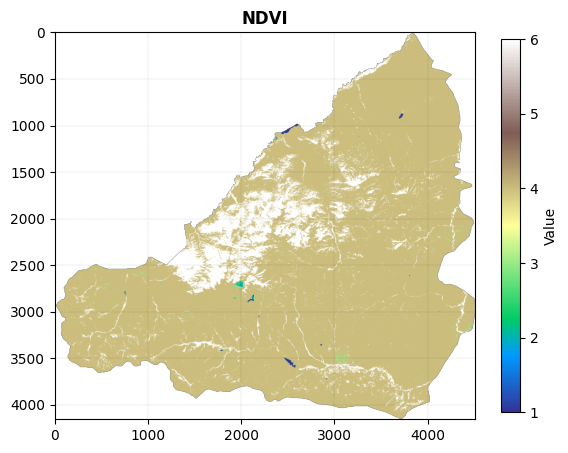

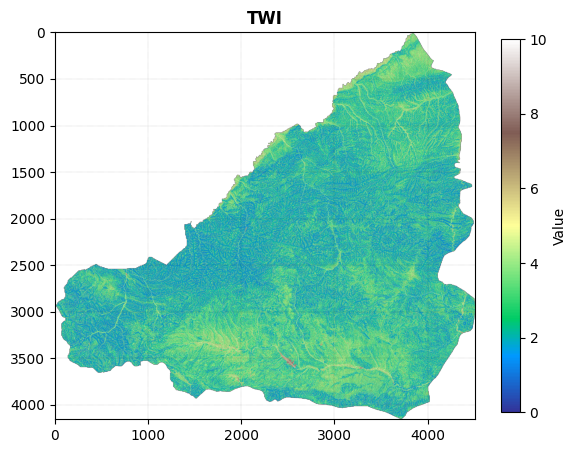

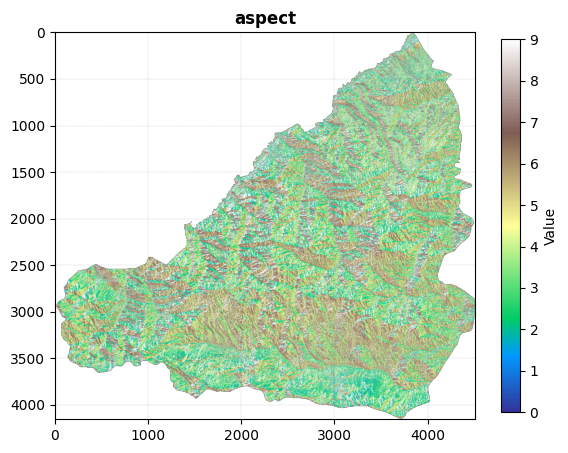

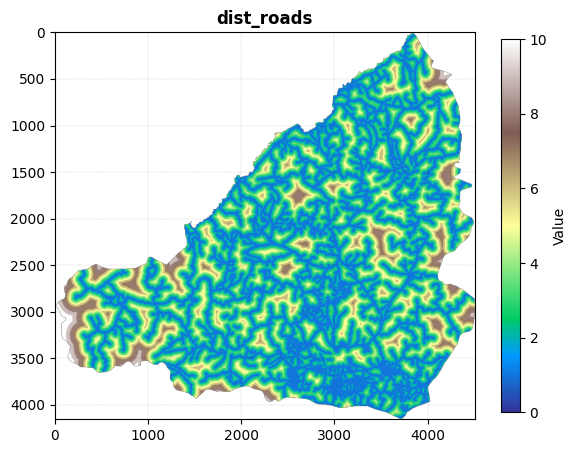

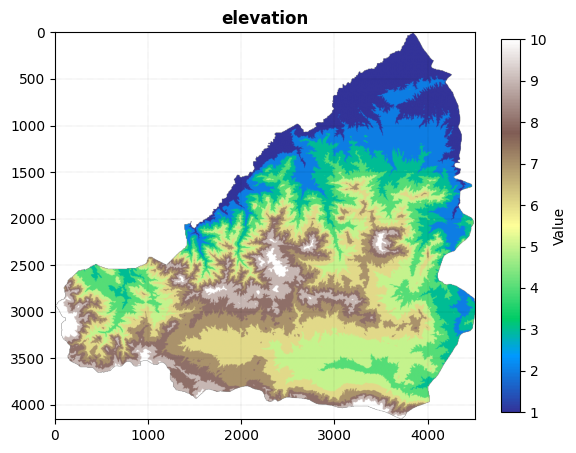

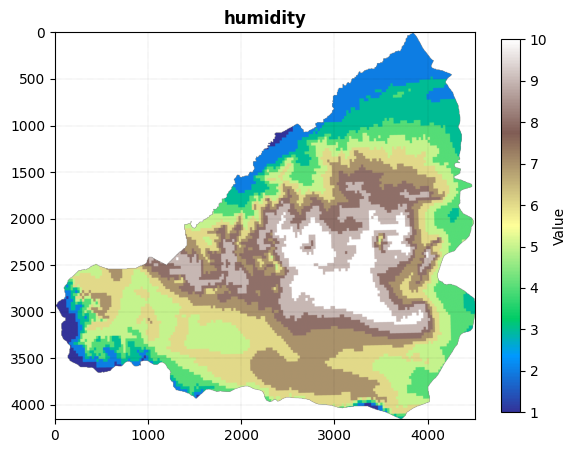

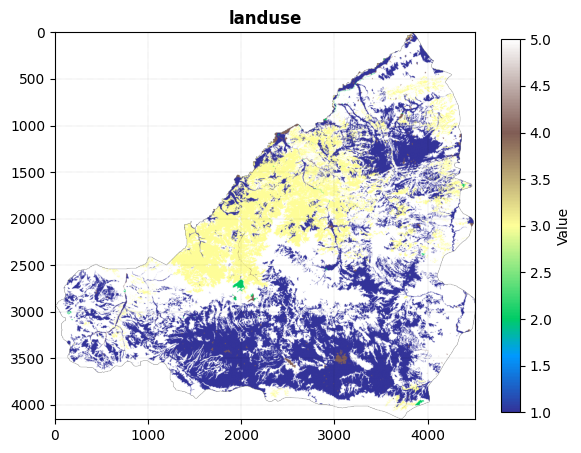

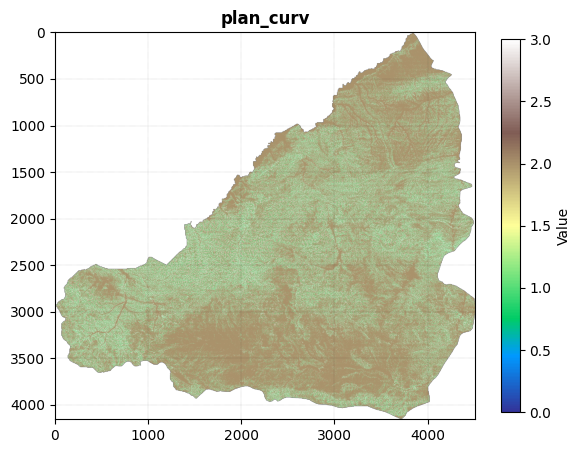

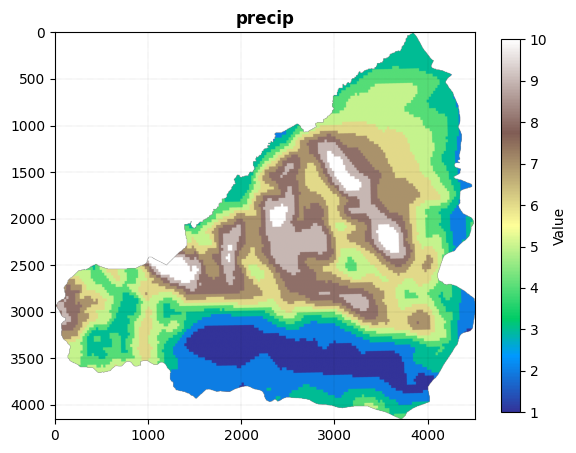

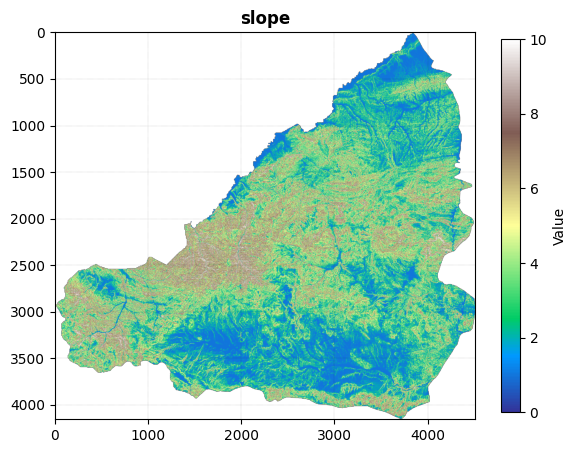

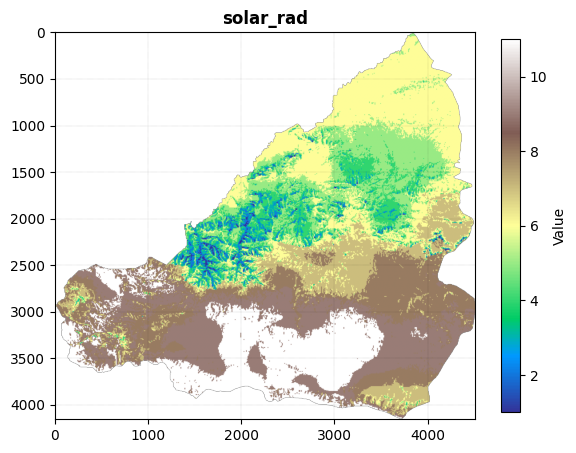

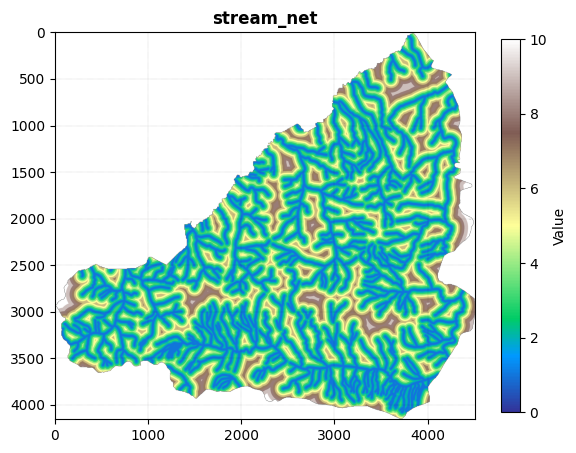

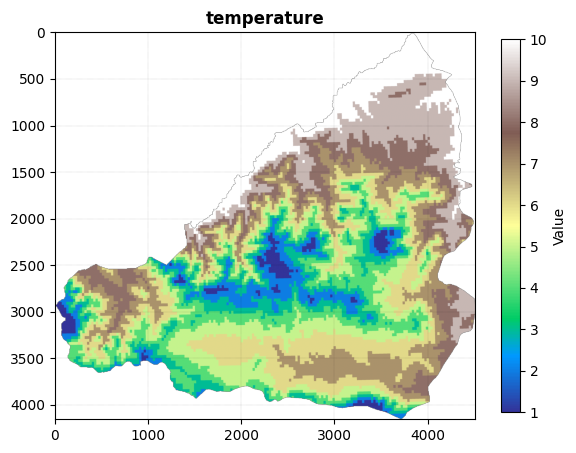

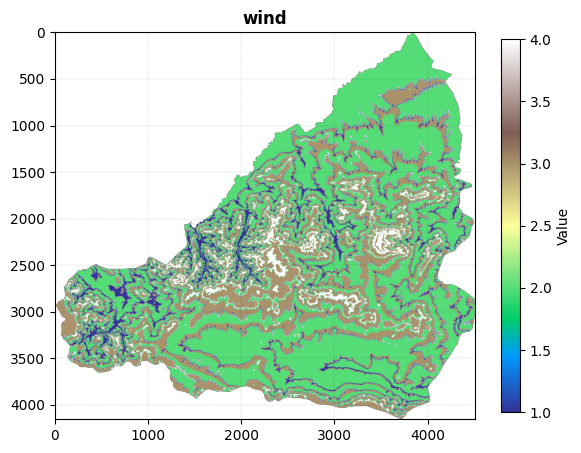

In [ ]:
def plot_raster(arr, title):
    plt.figure(figsize=(6, 5))
    im = plt.imshow(arr, cmap="terrain")
    plt.title(title, fontsize=12, weight="bold")
    plt.colorbar(im, shrink=0.8, label="Value")

    plt.grid(color="k", linestyle=":", linewidth=0.3, alpha=0.4)
    #plt.xlabel("Column")
    #plt.ylabel("Row")
    plt.tight_layout()
    plt.show()

for name, arr in layers.items():
    plot_raster(arr, name)



In [ ]:
fire_gdf = gpd.read_file("/content/drive/MyDrive/fire/fire2.shp")
fire_gdf = fire_gdf.to_crs(crs)

print(fire_gdf.head())
print("Intensity classes:", fire_gdf["Intensity"].unique())



   Id  Intensity                        geometry
0   0          1  POINT (678272.885 4319236.772)
1   0          1  POINT (683150.228 4322833.892)
2   0          1  POINT (681749.575 4315609.469)
3   0          1    POINT (677429.8 4325531.262)
4   0          1  POINT (679639.329 4326831.465)
Intensity classes: [1 3 2]


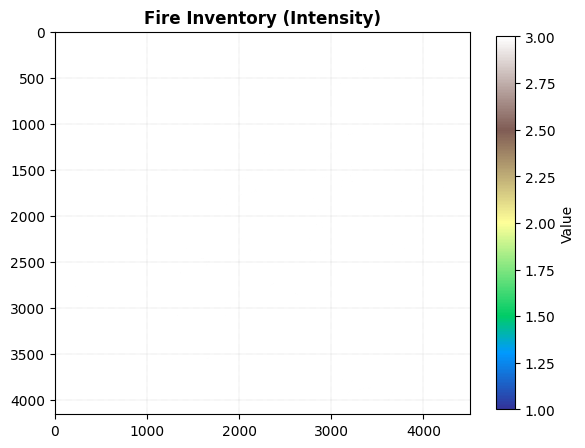

In [ ]:
fire_raster = rasterize(
    [(geom, val) for geom, val in zip(fire_gdf.geometry, fire_gdf["Intensity"])],
    out_shape=(min_rows, min_cols),
    transform=raster_meta[list(layers.keys())[0]][0], # در حالت عدم کاهش مقیاس
    #transform=new_transform, # این خط برای حالت کاهش مقیاس است
    fill=np.nan,
    dtype="float32"
)

#plot_raster(fire_raster, "Fire Inventory (Intensity)")


In [ ]:
X = []
y = []
coords = []

rows, cols = np.where(~np.isnan(fire_raster))

for r, c in zip(rows, cols):
    cls = int(fire_raster[r, c])   # ← مستقیم از shapefile

    feature = [layers[k][r, c] for k in layers]
    if np.any(np.isnan(feature)):
        continue

    X.append(feature)
    y.append(cls)
    coords.append([r, c])

X = np.array(X)
y = np.array(y)
coords = np.array(coords)

print("Fire samples extracted:", X.shape)
print("Class distribution (fire only):")
print(pd.Series(y).value_counts().sort_index())


Fire samples extracted: (128, 14)
Class distribution (fire only):
1    61
2    28
3    39
Name: count, dtype: int64


In [ ]:
print(y)

[1 2 1 1 1 2 1 1 3 3 3 1 1 1 1 1 1 1 2 2 1 1 2 2 1 2 3 2 1 3 1 1 2 1 1 2 3
 3 3 1 1 1 2 2 1 1 1 3 3 3 3 1 2 2 1 1 1 1 1 2 2 1 1 1 1 1 1 1 1 1 1 1 2 1
 2 1 1 3 3 3 3 3 3 2 2 3 1 3 3 3 3 3 1 1 3 3 3 1 1 1 1 1 1 1 3 3 3 2 2 1 2
 2 2 2 3 2 3 3 2 3 1 1 3 3 1 3 3 3]


In [ ]:
n_non_fire_percent = 0.5
n_non_fire = int(n_non_fire_percent * len(y))

non_fire_rows, non_fire_cols = np.where(np.isnan(fire_raster))
idx = np.random.choice(len(non_fire_rows), n_non_fire, replace=False)

X_non, y_non, coords_non = [], [], []

for i in idx:
    r, c = non_fire_rows[i], non_fire_cols[i]
    feature = [layers[k][r, c] for k in layers]

    if np.any(np.isnan(feature)):
        continue

    X_non.append(feature)
    y_non.append(0)   # No Fire
    coords_non.append([r, c])

X = np.vstack([X, np.array(X_non)])
y = np.concatenate([y, np.array(y_non)])
coords = np.vstack([coords, np.array(coords_non)])

print("Final dataset size:", X.shape)
print("Final class distribution:")
print(pd.Series(y).value_counts().sort_index())

Final dataset size: (167, 14)
Final class distribution:
0    39
1    61
2    28
3    39
Name: count, dtype: int64


In [ ]:
# ==========================================
# Build Spatial Feature Matrix for S-XGBoost
# ===========================================

# نرمال‌سازی مختصات به بازه [0, 1]
coord_max = np.array([min_rows - 1, min_cols - 1])
coords_norm = coords / coord_max

# اتصال فیچرها و مختصات
X_spatial = np.hstack([X, coords_norm])

print("Original X shape:", X.shape)
print("Spatial X shape:", X_spatial.shape)

Original X shape: (167, 14)
Spatial X shape: (167, 16)


In [ ]:
#=================================================
# Train & Test Split for RF, SVM, XGBoost, GWRF
#===================================================


X_train, X_test, y_train, y_test, coord_train, coord_test = train_test_split(
    X, y, coords,
    test_size=0.3,
    random_state=42,
    stratify=y
)

#=================================================
# Train & Test Split for S-XGBoost
#===================================================

Xtr, Xte, ytr, yte = train_test_split(
    X_spatial, y,
    test_size=0.3,
    random_state=42,
    stratify=y
)

In [ ]:
# ===========================================================
# OPTIONAL: Data Augmentation with Noise for the SAGE-XGBoost
# ===========================================================

USE_AUGMENTATION = True
AUG_RATIO = 0.95
NOISE_LEVEL = 0.03

if USE_AUGMENTATION:
    np.random.seed(42)

    n_samples = X.shape[0]
    n_aug = int(AUG_RATIO * n_samples)

    print(f"Applying data augmentation: +{n_aug} samples")

    idx = np.random.choice(n_samples, n_aug, replace=True)

    X_aug = X[idx].copy()
    y_aug = y[idx].copy()
    coords_aug = coords[idx].copy()

    feature_std = X.std(axis=0)

    noise = np.random.normal(
        loc=0.0,
        scale=NOISE_LEVEL * feature_std,
        size=X_aug.shape
    )

    X_aug = X_aug + noise

    X = np.vstack([X, X_aug])
    y = np.concatenate([y, y_aug])
    coords = np.vstack([coords, coords_aug])

    print("Dataset size after augmentation:", X.shape)
    print("Class distribution after augmentation:")
    print(pd.Series(y).value_counts().sort_index())
else:
    print("Data augmentation is OFF")


Applying data augmentation: +158 samples
Dataset size after augmentation: (325, 14)
Class distribution after augmentation:
0     75
1    118
2     56
3     76
Name: count, dtype: int64


In [ ]:
#================================================================================
# ساختن فیچر های همسایگی (Graph-based features) – Radius-free for SAGE-XGBoost
#================================================================================

from sklearn.neighbors import NearestNeighbors
from sklearn.decomposition import PCA

K = 18
nbrs = NearestNeighbors(n_neighbors=K+1, algorithm="kd_tree")
nbrs.fit(coords)

distances_knn, indices_knn = nbrs.kneighbors(coords)

indices_knn = indices_knn[:, 1:]
distances_knn = distances_knn[:, 1:]

neighbor_mean_env   = []
neighbor_std_env    = []
neighbor_wmean_env  = []
local_density       = []

for idxs, dists in zip(indices_knn, distances_knn):

    neigh_X = X[idxs]

    mean_env = np.mean(neigh_X, axis=0)
    std_env  = np.std(neigh_X, axis=0)

    neighbor_mean_env.append(mean_env)
    neighbor_std_env.append(std_env)

    weights = 1 / (dists + 1e-6)
    wmean_env = np.sum(neigh_X * weights[:, None], axis=0) / np.sum(weights)
    neighbor_wmean_env.append(wmean_env)

    local_density.append(1 / (np.mean(dists) + 1e-6))

neighbor_mean_env   = np.array(neighbor_mean_env)
neighbor_std_env    = np.array(neighbor_std_env)
neighbor_wmean_env  = np.array(neighbor_wmean_env)
local_density       = np.array(local_density).reshape(-1, 1)

graph_feats = np.hstack([
    neighbor_mean_env,
    neighbor_wmean_env,
    neighbor_std_env,
    local_density
])

print("Graph feature matrix shape:", graph_feats.shape)

EMB_DIM = 3
pca = PCA(n_components=EMB_DIM, random_state=42)
graph_embedding = pca.fit_transform(graph_feats)

print("Graph embedding shape:", graph_embedding.shape)
print("Explained variance ratio:", pca.explained_variance_ratio_)


Graph feature matrix shape: (325, 43)
Graph embedding shape: (325, 3)
Explained variance ratio: [0.40078237 0.26085928 0.07306957]


In [ ]:
# ==============================================
# Build Spatial Feature Matrix for SAGE-XGBoost
# ==============================================

# نرمال‌سازی مختصات به بازه [0, 1]
coord_max = np.array([min_rows - 1, min_cols - 1])
coords_norm = coords / coord_max

In [ ]:
# ==================================================================
# 6. اتصال نهایی به داده‌ها (برای Spatial + Graph  in SAGE-XGBoost)
# ==================================================================

X_graph = np.hstack([
    X,             # ویژگی‌های محیطی
    coords_norm,   # مختصات مکانی
    graph_embedding
])

print("Final feature matrix shape (Graph-Embedded):", X_graph.shape)

print("Graph-enhanced X shape:", X_graph.shape)


Final feature matrix shape (Graph-Embedded): (325, 19)
Graph-enhanced X shape: (325, 19)


In [ ]:
#=================================================
# Train & Test Split for SAGE-XGBoost
#===================================================
Xtr2, Xte2, ytr2, yte2 = train_test_split(
    X_graph, y,
    test_size=0.3,
    random_state=42,
    stratify=y
)



In [ ]:
rf = RandomForestClassifier(random_state=42)

rf_params = {
    "n_estimators": [100, 200, 300],
    "max_depth": [10, 20, None],
    "min_samples_split": [2, 5]
}


rf_gs = GridSearchCV(
    rf,
    rf_params,
    cv=5,
    scoring='f1_weighted',  # ← اصلاح اصلی    # scoring='f1_macro'
    n_jobs=-1
)

rf_gs.fit(X_train, y_train)

rf_best = rf_gs.best_estimator_

print("Best RF parameters:", rf_gs.best_params_)


Best RF parameters: {'max_depth': 20, 'min_samples_split': 2, 'n_estimators': 300}


In [ ]:
xgb = XGBClassifier(
    objective='multi:softprob',
    num_class=4,              # کلاس‌های 0,1,2,3
    eval_metric='mlogloss',
    tree_method='hist',
    random_state=42
)


xgb_params = {
    "n_estimators": [100, 200],
    "max_depth": [3, 6],
    "learning_rate": [0.05, 0.1],
    "subsample": [0.8, 1.0],
    "colsample_bytree": [0.8, 1.0]
}

xgb_gs = GridSearchCV(
    xgb,
    xgb_params,
    cv=5,
    scoring='f1_weighted',
    n_jobs=-1
)

xgb_gs.fit(X_train, y_train)

xgb_best = xgb_gs.best_estimator_

print("Best XGBoost parameters:", xgb_gs.best_params_)



Best XGBoost parameters: {'colsample_bytree': 0.8, 'learning_rate': 0.05, 'max_depth': 3, 'n_estimators': 200, 'subsample': 1.0}


In [ ]:
# Spatial XGBoost
xgb_spatial = XGBClassifier(
    objective="multi:softprob",
    num_class=4,
    eval_metric="mlogloss",
    tree_method="hist",   # اگر GPU داشتی: gpu_hist
    random_state=42
)


xgb_params = {
    "n_estimators": [100, 200, 300, 400],
    "max_depth": [4, 6],
    "learning_rate": [0.05, 0.1],
    "subsample": [0.8, 1.0],
    "colsample_bytree": [0.8, 1.0]
}

s_xgb_gs = GridSearchCV(
    xgb_spatial,
    xgb_params,
    cv=5,
    scoring="f1_weighted",
    n_jobs=-1,
    verbose=1
)

s_xgb_gs.fit(Xtr, ytr)

xgb_spatial_best = s_xgb_gs.best_estimator_

print("Best params:", s_xgb_gs.best_params_)

Fitting 5 folds for each of 64 candidates, totalling 320 fits
Best params: {'colsample_bytree': 0.8, 'learning_rate': 0.05, 'max_depth': 4, 'n_estimators': 400, 'subsample': 0.8}


In [ ]:
# SAGE-XGBoost
xgb_spatGraph = XGBClassifier(
    objective="multi:softprob",
    num_class=4,
    eval_metric="mlogloss",
    tree_method="hist",   # اگر GPU داشتی: gpu_hist
    random_state=42
)


xgb_params = {
    "n_estimators": [100, 200, 300, 400],
    "max_depth": [4, 6],
    "learning_rate": [0.05, 0.1],
    "subsample": [0.8, 1.0],
    "colsample_bytree": [0.8, 1.0]
}

s_xgb_gs2 = GridSearchCV(
    xgb_spatGraph,
    xgb_params,
    cv=5,
    scoring="f1_weighted",
    n_jobs=-1,
    verbose=1
)

s_xgb_gs2.fit(Xtr2, ytr2)

xgb_spatGraph_best = s_xgb_gs2.best_estimator_

print("Best params:", s_xgb_gs2.best_params_)

Fitting 5 folds for each of 64 candidates, totalling 320 fits
Best params: {'colsample_bytree': 1.0, 'learning_rate': 0.1, 'max_depth': 6, 'n_estimators': 100, 'subsample': 1.0}


In [ ]:
#SVM
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV

svm_pipe = Pipeline([
    ("scaler", StandardScaler()),
    ("svm", SVC(probability=True, decision_function_shape='ovr'))
])

svm_params = {
    "svm__C": [1, 10, 20],
    "svm__gamma": ['scale', 0.1],
    "svm__kernel": ['rbf']
}

svm_gs = GridSearchCV(
    svm_pipe,
    svm_params,
    cv=5,
    scoring='f1_weighted',   # ← اصلاح کلیدی
    n_jobs=-1
)

svm_gs.fit(X_train, y_train)

svm_best = svm_gs.best_estimator_

print("Best SVM parameters:", svm_gs.best_params_)



Best SVM parameters: {'svm__C': 10, 'svm__gamma': 0.1, 'svm__kernel': 'rbf'}


In [ ]:
#GWRF
from scipy.spatial.distance import cdist
from sklearn.metrics import f1_score

def spatial_weights(train_coords, target_coord, bandwidth):
    dists = cdist(train_coords, target_coord.reshape(1, -1)).ravel()
    return np.exp(-(dists**2) / (2 * bandwidth**2))

bandwidths = [20, 40, 60]
n_estimators_list = [100, 200]
max_depths = [None, 15]


best_score = -np.inf
best_params = None
best_pred = None

for bw in bandwidths:
    for n_est in n_estimators_list:
        for md in max_depths:

            y_pred = []

            for i in range(len(X_test)):
                w = spatial_weights(coord_train, coord_test[i], bw)

                rf_local = RandomForestClassifier(
                    n_estimators=n_est,
                    max_depth=md,
                    random_state=42,
                    n_jobs=-1
                )

                rf_local.fit(X_train, y_train, sample_weight=w)
                y_pred.append(
                    rf_local.predict(X_test[i].reshape(1, -1))[0]
                )

            y_pred = np.array(y_pred)

            score = f1_score(y_test, y_pred, average="weighted")

            print(f"BW={bw}, Trees={n_est}, Depth={md} → F1w={score:.3f}")

            if score > best_score:
                best_score = score
                best_params = (bw, n_est, md)
                best_pred = y_pred

print("\nBest GWRF configuration:")
print(f"Bandwidth={best_params[0]}")
print(f"n_estimators={best_params[1]}")
print(f"max_depth={best_params[2]}")
print(f"Best F1-weighted={best_score:.3f}")


BW=20, Trees=100, Depth=None → F1w=0.626
BW=20, Trees=100, Depth=15 → F1w=0.626
BW=20, Trees=200, Depth=None → F1w=0.624
BW=20, Trees=200, Depth=15 → F1w=0.624
BW=40, Trees=100, Depth=None → F1w=0.653
BW=40, Trees=100, Depth=15 → F1w=0.653
BW=40, Trees=200, Depth=None → F1w=0.655
BW=40, Trees=200, Depth=15 → F1w=0.655
BW=60, Trees=100, Depth=None → F1w=0.631
BW=60, Trees=100, Depth=15 → F1w=0.631
BW=60, Trees=200, Depth=None → F1w=0.647
BW=60, Trees=200, Depth=15 → F1w=0.647

Best GWRF configuration:
Bandwidth=40
n_estimators=200
max_depth=None
Best F1-weighted=0.655


In [ ]:
#پلات ترسیم ماتریس درهمریختگی به صورت حرارتی
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

def plot_confusion_matrix_percent(y_true, y_pred, class_names, title):

    cm = confusion_matrix(y_true, y_pred)

    # نرمال‌سازی سطری (Recall-based percentage)
    cm_percent = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis] * 100

    plt.figure(figsize=(6,5))
    im = plt.imshow(cm_percent, interpolation='nearest')
    plt.title(title, weight='bold')
    plt.colorbar(im, fraction=0.046, pad=0.04)

    tick_marks = np.arange(len(class_names))
    plt.xticks(tick_marks, class_names, rotation=45)
    plt.yticks(tick_marks, class_names)

    # نوشتن درصد داخل خانه‌ها
    for i in range(cm_percent.shape[0]):
        for j in range(cm_percent.shape[1]):
            value = cm_percent[i, j]
            plt.text(
                j, i,
                f"{value:.1f}%",
                ha="center",
                va="center",
                color="white" if value > 50 else "black",
                fontsize=10
            )

    plt.ylabel('True Class')
    plt.xlabel('Predicted Class')
    plt.tight_layout()
    plt.show()


In [ ]:
models = {
    "Random Forest": rf_best,
    "XGBoost": xgb_best,
    "SVM": svm_best
}

for name, model in models.items():
    pred = model.predict(X_test)
    print("======", name, "======")
    print(confusion_matrix(y_test, pred))
    print(classification_report(y_test, pred))

# GWRF
print("\n====== Geographical Random Forest ======")
print(confusion_matrix(y_test, best_pred))
print(classification_report(y_test, best_pred))

#Spatial XGBoost
pred = xgb_spatial_best.predict(Xte)

print("====== Spatial XGBoost ======")
print(confusion_matrix(yte, pred))
print(classification_report(yte, pred))

#Spatial & Graph XGBoost
pred = xgb_spatGraph_best.predict(Xte2)

print("====== SAGE-XGBoost ======")
print(confusion_matrix(yte2, pred))
print(classification_report(yte2, pred))


====== Random Forest ======
[[ 5  4  2  1]
 [ 3 13  1  2]
 [ 1  4  2  1]
 [ 1  4  0  7]]
              precision    recall  f1-score   support

           0       0.50      0.42      0.45        12
           1       0.52      0.68      0.59        19
           2       0.40      0.25      0.31         8
           3       0.64      0.58      0.61        12

    accuracy                           0.53        51
   macro avg       0.51      0.48      0.49        51
weighted avg       0.52      0.53      0.52        51

====== XGBoost ======
[[4 5 1 2]
 [5 7 5 2]
 [1 4 2 1]
 [3 3 0 6]]
              precision    recall  f1-score   support

           0       0.31      0.33      0.32        12
           1       0.37      0.37      0.37        19
           2       0.25      0.25      0.25         8
           3       0.55      0.50      0.52        12

    accuracy                           0.37        51
   macro avg       0.37      0.36      0.37        51
weighted avg       0.38      

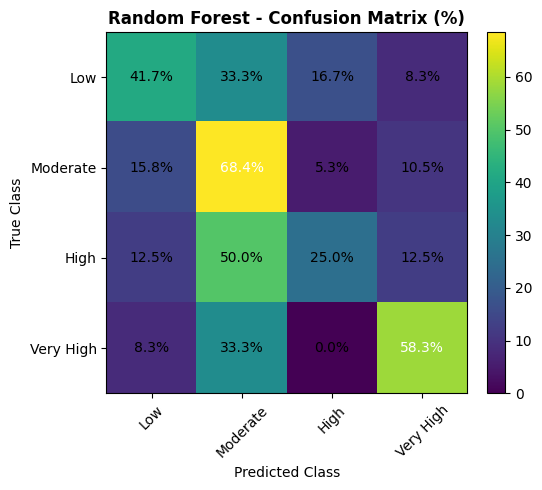

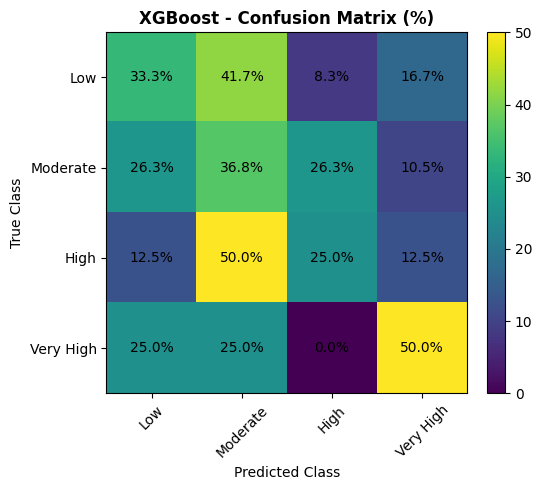

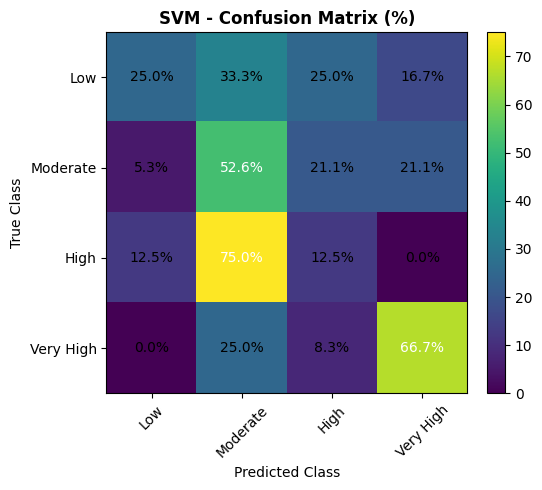

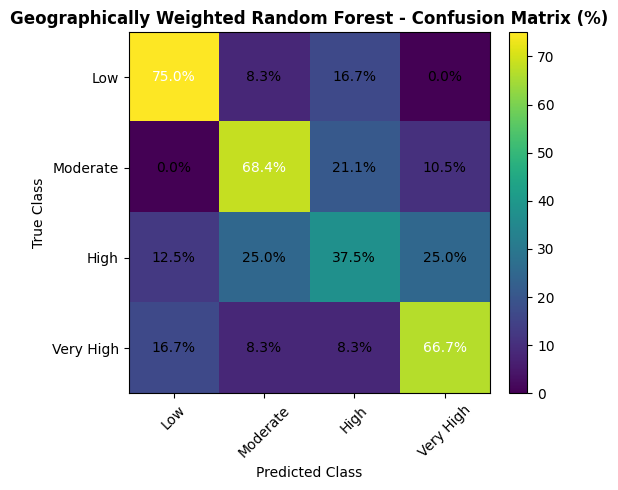

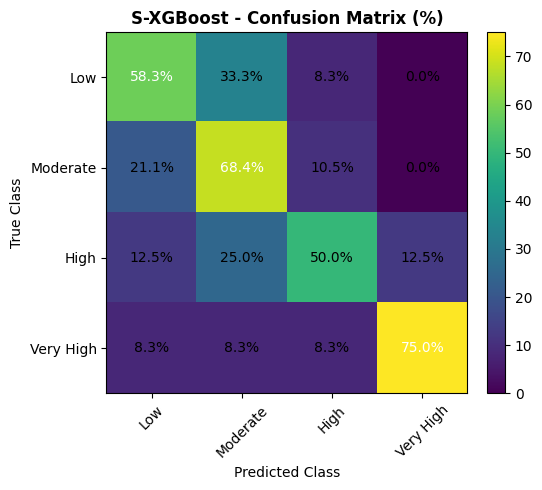

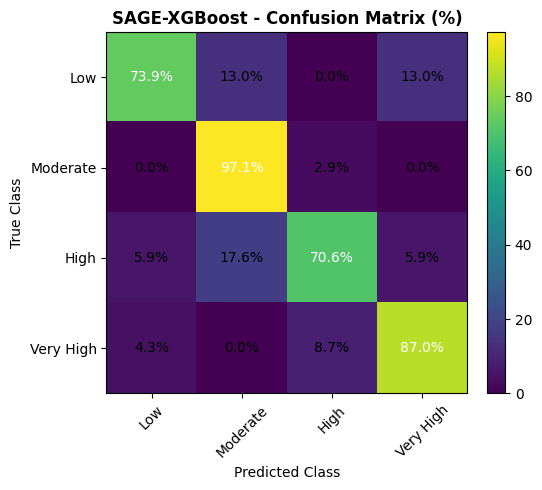

In [ ]:
class_names = ["Low", "Moderate", "High", "Very High"]

models = {
    "Random Forest": rf_best,
    "XGBoost": xgb_best,
    "SVM": svm_best
}

for name, model in models.items():
    pred = model.predict(X_test)
    plot_confusion_matrix_percent(
        y_test, pred,
        class_names,
        f"{name} - Confusion Matrix (%)"
    )

plot_confusion_matrix_percent(
    y_test, best_pred,
    class_names,
    "Geographically Weighted Random Forest - Confusion Matrix (%)"
)

pred = xgb_spatial_best.predict(Xte)

plot_confusion_matrix_percent(
    yte, pred,
    class_names,
    "S-XGBoost - Confusion Matrix (%)"
)

pred = xgb_spatGraph_best.predict(Xte2)

plot_confusion_matrix_percent(
    yte2, pred,
    class_names,
    "SAGE-XGBoost - Confusion Matrix (%)"
)



In [ ]:
#======================
# ROC
#==================

roc_storage = {}

from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import label_binarize
import numpy as np

def compute_and_store_roc(model, X, y, model_name, n_classes):

    # باینری‌سازی کلاس‌ها
    y_bin = label_binarize(y, classes=range(n_classes))

    # گرفتن probability ها
    y_score = model.predict_proba(X)

    fpr = dict()
    tpr = dict()
    roc_auc = dict()

    for i in range(n_classes):
        fpr[i], tpr[i], _ = roc_curve(y_bin[:, i], y_score[:, i])
        roc_auc[i] = auc(fpr[i], tpr[i])

    # Macro-average
    all_fpr = np.unique(np.concatenate([fpr[i] for i in range(n_classes)]))

    mean_tpr = np.zeros_like(all_fpr)
    for i in range(n_classes):
        mean_tpr += np.interp(all_fpr, fpr[i], tpr[i])

    mean_tpr /= n_classes
    macro_auc = auc(all_fpr, mean_tpr)

    # ذخیره در دیکشنری
    roc_storage[model_name] = {
        "fpr": all_fpr,
        "tpr": mean_tpr,
        "auc": macro_auc
    }

    print(f"{model_name} AUC (Macro): {macro_auc:.3f}")


n_classes = 4

compute_and_store_roc(rf_best, X_test, y_test, "RF", n_classes)
compute_and_store_roc(xgb_best, X_test, y_test, "XGBoost", n_classes)
compute_and_store_roc(svm_best, X_test, y_test, "SVM", n_classes)

compute_and_store_roc(xgb_spatial_best, Xte, yte, "S-XGBoost", n_classes)
compute_and_store_roc(xgb_spatGraph_best, Xte2, yte2, "SAGE-XGBoost", n_classes)



import matplotlib.pyplot as plt

def plot_selected_rocs(model_names):

    plt.figure(figsize=(7,6))

    for name in model_names:
        data = roc_storage[name]
        plt.plot(
            data["fpr"],
            data["tpr"],
            label=f"{name} (AUC = {data['auc']:.3f})"
        )

    plt.plot([0,1],[0,1], linestyle="--")

    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.title("ROC Curve Comparison", weight="bold")
    plt.legend()
    plt.grid(alpha=0.3)
    plt.tight_layout()
    plt.show()


plot_selected_rocs([
    "S-XGBoost",
    "SAGE-XGBoost",
    "RF",
    "SVM",
    "XGBoost",
    "GWRF"
])

plot_selected_rocs(list(roc_storage.keys()))



